<a href="https://colab.research.google.com/github/AarnavSawant/SpaceInvadersAI/blob/main/SpaceInvadersAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
import random
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
from collections import namedtuple

In [ ]:
%env
CUDA_LAUNCH_BLOCKING=1

In [ ]:
# Check if GPU Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # if gpu is to be used

In [ ]:
# Create OpenAIGYm Environment
env = gym.make("SpaceInvaders-v0").unwrapped
env = gym.wrappers.Monitor(env, "/content/drive/My Drive/SpaceInvadersDay3", video_callable=lambda episode_id: True, force=True)

In [ ]:
# Implementing Experience Replay so that the agent can uniformly sample experiences
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state"])
class ExperienceReplay(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0
  def push(self, *args):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity
  def sample(self, BATCH_SIZE):
    return random.sample(self.memory, BATCH_SIZE)
  def __len__(self):
    return len(self.memory)

In [ ]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [ ]:
# Main Model Architecture
class QNetwork(nn.Module):
  def __init__(self, height, width, n_actions):
    super(QNetwork, self).__init__()
    self.conv1 = nn.Conv2d(4, 16, 8, 4, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 4, 2, padding=0)
    def getConvOutputSize(size, kernel_size=5, stride=2):
      return (size - kernel_size + 2*0) // stride + 1
    convolvedWidth = getConvOutputSize(getConvOutputSize(width, 8, 4), 4, 2)
    convolvedHeight = getConvOutputSize(getConvOutputSize(height, 8, 4), 4, 2)
    self.linear1 = nn.Linear(convolvedWidth * 32 * convolvedHeight, 256)
    self.linear2 = nn.Linear(256, n_actions)
  def forward(self, x):
    x = x.float()
    x = x.to(device)
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.linear2(self.linear1(x.view(x.size(0), -1)))
    return x


In [ ]:
from PIL import Image
from collections import deque
transforms = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])
import cv2
stack_size = 4
stacked_frames = deque([np.zeros((84, 84)) for i in range(stack_size)], maxlen=stack_size)

#Using Stacked Frames to account for movement 
def get_screen(state, is_new_episode):

  frame = state
  global stacked_frames
  # print(len(stacked_frames))
  stacked_state = None
  frame = resize(rgb2gray(frame), (84, 84))
  if is_new_episode:
    stacked_frames = deque([np.zeros((84, 84)) for i in range(stack_size)], maxlen=stack_size)
    maxFrame = np.maximum(frame, frame)
    stacked_frames.append(maxFrame)
    stacked_frames.append(maxFrame)
    stacked_frames.append(maxFrame)
    stacked_frames.append(maxFrame)
    stacked_state = np.stack(stacked_frames, axis=2)
  else:
    last_frame = stacked_frames[-1]
    # Take the element_wise maximum of last_frame and frame to account for motion
    maxFrame = np.maximum(last_frame, frame)
    stacked_frames.append(maxFrame)
    stacked_state = np.stack(stacked_frames, axis=2)
  frame = torch.from_numpy(stacked_state.transpose((2, 0, 1)))
  return frame.unsqueeze(0).to(device)


In [ ]:
frame = get_screen(env.render(mode="rgb_array"), True)

In [ ]:
print(frame.shape)

torch.Size([1, 84, 84, 4])


In [ ]:
# Constants/Initialization
BATCH_SIZE = 128
EPSILON_START = 1.0
import math
EPSILON_END = 0.1
learning_rate =0.001
EPSILON_DECAY = 500000
n_actions = env.action_space.n
experienceReplay = ExperienceReplay(20000)
policyNet = QNetwork(84, 84, n_actions).to(device)
targetNet = QNetwork(84, 84, n_actions).to(device)
targetNet.load_state_dict(policyNet.state_dict())

optimizer = optim.Adam(policyNet.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss().to(device)

In [ ]:
# Use Epsilon Decay for Exploration vs. Exploitation
steps_done = 386371
def select_action(state, n_actions):
  global steps_done
  epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done/EPSILON_DECAY)
  # print(epsilon)
  steps_done += 1
  randomNum = random.random()
  if randomNum > epsilon:
    probabilities = policyNet(state)
    top_Q = torch.argmax(probabilities).to(device).item()
  else:
    top_Q = torch.tensor(random.randint(0, n_actions - 1)).to(device).item()
  return top_Q

In [ ]:
frame = get_screen(env.render(mode="rgb_array"), True)


In [ ]:
select_action(get_screen(), n_actions)

0.9


9

In [ ]:
# Use 0.97 as the discount factor for V(s')
GAMMA = 0.97
running_loss = 0
def optimize_model():
  global running_loss
  if len(experienceReplay.memory) < 128:
    return
  optimizer.zero_grad()
  # Create a Named Tuple from the ExperienceReplay
  transitions = Transition(*zip(*experienceReplay.sample(BATCH_SIZE)))
  # Create a map of states where the next state is not None or GAME OVER
  non_final_next_state = tuple(map(lambda x: x is not None, transitions.next_state))
  # Gather all of the Next States (Frames)
  batch_next_state = torch.cat([t for t in transitions.next_state if t is not None])
  # Gather all of the States (frames)
  batch_state = torch.cat(transitions.state).to(device)
  # Gather all of the Actions (0...6)
  batch_actions = torch.tensor(transitions.action).unsqueeze(1).to(device)
  # Gather the reward from taking an action at a given state
  batch_reward = torch.cat(transitions.reward).to(device)
  # Compute the Q values for each action possible at each of the batch states
  Q_s_a = policyNet(batch_state)
  # print(Q_s_a.shape)
  # Gather the Q Value for the action the agent took at that state
  Q_s_a = Q_s_a.gather(-1, batch_actions)
  # Instantiate a tensor of zeros in the size of the batch_size
  next_state_v_values = torch.zeros(BATCH_SIZE).to(device)
  # Replace all of the v_values where next_state is not the terminal screen with the Q values of the next_state
  next_state_v_values[non_final_next_state] = torch.max(targetNet(batch_next_state))
  # Use the Markov Decision Process V(s) = R(s, a) + GAMMA * V(s') to Calculate the Target V-Values
  expected_state_v_values = batch_reward + GAMMA * next_state_v_values
  Q_s_a = Q_s_a.squeeze()
  # Compute the L1 Loss
  loss = criterion(Q_s_a, expected_state_v_values)
  loss_value = loss.item()
  running_loss += loss_value
  # Back Propogation
  loss.backward()
  # Gradient Clipping to avoid Exploding Gradient
  for param in policyNet.parameters():
        param.grad.data.clamp_(-1, 1)



In [ ]:
#  For multi-day training, load the state_dict from the last time the model was trained due to Colab Session Restrictions
policy_state_dict = torch.load("drive/MyDrive/SpaceInvadersDay2/policyNet", map_location=device)
policyNet.load_state_dict(policy_state_dict)
target_state_dict = torch.load("drive/MyDrive/SpaceInvadersDay2/targetNet", map_location=device)
targetNet.load_state_dict(target_state_dict)
optimizer_state_dict = torch.load("drive/MyDrive/SpaceInvadersDay2/optimizer", map_location=device)
optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
reward_over_time = []
with open("drive/My Drive/SpaceInvadersDay2/rewardfile.txt", "r") as f:
  for line in f:
    r = line[:-1]
    reward_over_time.append(int(r))
states_per_episode = []
with open("drive/My Drive/SpaceInvadersDay2/statesfile.txt", "r") as f:
  for line in f:
    r = line[:-1]
    states_per_episode.append(int(r))
loss_over_time = []
with open("drive/My Drive/SpaceInvadersDay2/lossfile.txt", "r") as f:
  for line in f:
    r = line[:-1]
    loss_over_time.append(r)



In [ ]:
print(reward_over_time)
print(loss_over_time)
print(states_per_episode)

[75, 55, 155, 95, 65, 55, 100, 790, 100, 180, 80, 105, 100, 80, 380, 80, 90, 105, 595, 165, 20, 55, 195, 75, 35, 160, 100, 480, 155, 190, 50, 155, 260, 65, 75, 485, 180, 110, 105, 110, 110, 110, 515, 125, 35, 15, 195, 155, 80, 180, 155, 170, 135, 155, 80, 215, 105, 80, 215, 135, 210, 45, 135, 265, 410, 135, 155, 100, 250, 110, 50, 270, 340, 50, 90, 180, 80, 180, 210, 180, 120, 55, 50, 45, 490, 530, 105, 105, 110, 95, 105, 50, 110, 65, 340, 165, 80, 75, 160, 155, 50, 180, 335, 110, 190, 110, 100, 110, 195, 210, 240, 135, 440, 120, 110, 210, 180, 215, 215, 155, 180, 75, 55, 290, 180, 180, 155, 240, 105, 150, 45, 135, 135, 180, 35, 105, 130, 110, 110, 135, 315, 175, 105, 150, 140, 90, 180, 260, 45, 160, 155, 545, 50, 120, 180, 210, 165, 155, 95, 135, 215, 120, 110, 460, 105, 140, 155, 225, 115, 120, 105, 20, 165, 210, 155, 105, 105, 110, 210, 415, 60, 210, 5, 425, 20, 260, 180, 210, 105, 365, 75, 110, 35, 180, 125, 165, 240, 515, 280, 45, 120, 110, 80, 230, 100, 225, 210, 180, 120, 240, 2

In [ ]:
# Main Loop
NUM_EPISODES = 2000
running_reward = 0
states_per_episode = []
loss_over_time = []
next_state = None
reward_over_time = []
from itertools import count
for i in range(0, 2000):
  env.reset()
  # Get the current stack of frames
  state = get_screen(env.render(mode="rgb_array"), True)
  global next_state
  global running_loss
  running_loss = 0
  running_reward = 0
  for c in count():
    if c % 100 == 0:
      # print
      # Save Network's Weights Every 100 steps
      torch.save(policyNet.state_dict(), "drive/My Drive/SpaceInvadersDay3/policyNet")
      torch.save(targetNet.state_dict(), "drive/My Drive/SpaceInvadersDay3/targetNet")
      torch.save(optimizer.state_dict(), "drive/My Drive/SpaceInvadersDay3/optimizer")
    # Select Action from state
    action = select_action(state, n_actions)
    # Take the action
    next_state, reward, done, _ = env.step(action)
    # Get the next stack of frames
    next_state = get_screen(next_state, True)
    running_reward += reward
    reward = torch.tensor([reward])
    if not done:
      # Make the current state tge next state and keep going
      state = next_state
    else:
      # If Agent Died, Append the Number of states in the current episode, the reward, and the loss
      states_per_episode.append(c + 1)
      reward_over_time.append(running_reward)
      loss_over_time.append(running_loss/(c+1))
      print("EPISODE", i + 1, "STATES", c + 1, "Average Loss/Step", format(running_loss/(c+1), ".2f"), "REWARD", running_reward)
      break
    experienceReplay.push(state, action, reward, next_state)
    loss = optimize_model()
  

  # Every 10 episodes, replace target weights with policyNet's weights
  if i % 10 == 0:
    targetNet.load_state_dict(policyNet.state_dict())

  # Plot
  plt.plot(reward_over_time)
  plt.title("Reward over Episode")
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.savefig("drive/My Drive/SpaceInvadersDay3/Reward.jpg")
  plt.clf()
  plt.plot(states_per_episode)
  plt.title("States per Episode")
  plt.xlabel("Episode")
  plt.ylabel("States")
  plt.savefig("drive/My Drive/SpaceInvadersDay3/States.jpg")
  plt.clf()
  plt.plot(loss_over_time)
  plt.title("Average Loss per State over Episode")
  plt.xlabel("Episode")
  plt.ylabel("Average Loss")
  plt.savefig("drive/My Drive/SpaceInvadersDay3/Loss.jpg")
  plt.clf()








EPISODE 576 STATES 787 Average Loss/Step 0.06 REWARD 195.0
EPISODE 577 STATES 992 Average Loss/Step 0.25 REWARD 315.0
EPISODE 578 STATES 403 Average Loss/Step 0.27 REWARD 105.0
EPISODE 579 STATES 1005 Average Loss/Step 0.28 REWARD 320.0
EPISODE 580 STATES 724 Average Loss/Step 0.27 REWARD 135.0
EPISODE 581 STATES 817 Average Loss/Step 0.27 REWARD 180.0
EPISODE 582 STATES 803 Average Loss/Step 0.26 REWARD 155.0
EPISODE 583 STATES 615 Average Loss/Step 0.24 REWARD 110.0
EPISODE 584 STATES 649 Average Loss/Step 0.26 REWARD 120.0
EPISODE 585 STATES 595 Average Loss/Step 0.23 REWARD 105.0
EPISODE 586 STATES 1110 Average Loss/Step 0.24 REWARD 330.0
EPISODE 587 STATES 1510 Average Loss/Step 0.24 REWARD 410.0
EPISODE 588 STATES 592 Average Loss/Step 0.22 REWARD 110.0
EPISODE 589 STATES 539 Average Loss/Step 0.23 REWARD 105.0
EPISODE 590 STATES 1086 Average Loss/Step 0.24 REWARD 315.0
EPISODE 591 STATES 468 Average Loss/Step 0.24 REWARD 55.0
EPISODE 592 STATES 618 Average Loss/Step 0.23 REWARD 

In [ ]:
moving_average_reward = [0 for i in range(20)]
for i in range(20, len(reward_over_time)):
  moving_average = np.mean(reward_over_time[i-20:i])
  moving_average_reward.append(moving_average)


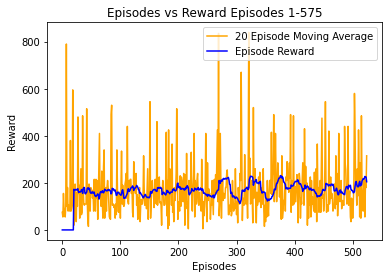

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.clf()
plt.plot(reward_over_time, color="orange", label="20 Episode Moving Average")
plt.plot(moving_average_reward, color="blue", label="Episode Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Episodes vs Reward Episodes 1-575")
plt.legend()
plt.show()
plt.savefig("drive/My Drive/SpaceInvadersDay2/Reward1-575.jpg")

In [ ]:
with open("drive/My Drive/SpaceInvadersDay2/rewardfile.txt", "w") as f:
  for r in reward_over_time:
    f.write("%d\n" % r)
with open("drive/My Drive/SpaceInvadersDay2/lossfile.txt", "w") as f:
  for r in loss_over_time:
    f.write("%d\n" % r)
with open("drive/My Drive/SpaceInvadersDay2/statesfile.txt", "w") as f:
  for r in states_per_episode:
    f.write("%d\n" % r)

Text(0, 0.5, 'Reward')

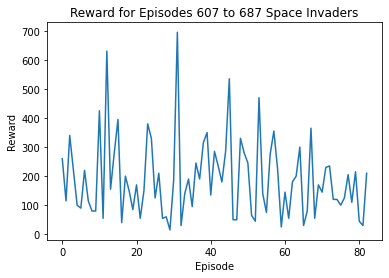

In [ ]:
plt.plot(reward_over_time)
plt.title("Reward for Episodes 607 to 687 Space Invaders")
plt.xlabel("Episode")
plt.ylabel("Reward")